In [1]:
from bs4 import BeautifulSoup
import requests
import csv
import json
import xml
import pandas as pd

column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(url).text
soup = BeautifulSoup(source, 'lxml')#Beautiful Soup to Parse the url page
table=soup.find('table')
x=table.tbody

postcode = 0
borough = 0
neighborhood = 0

for tr in x.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2:
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)
    
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1
                                 
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()


df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]


def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [3]:
import geocoder

def get_latlng(postal_code):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
    return lat_lng_coords

postal_codes = df2['Postalcode']    
coords = [ get_latlng(postal_code) for postal_code in postal_codes.tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

In [4]:
df

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.811525,-79.195517
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.785730,-79.158750
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765690,-79.175256
3,M1G,Scarborough,Woburn,43.768359,-79.217590
4,M1H,Scarborough,Cedarbrae,43.769688,-79.239440
5,M1J,Scarborough,Scarborough Village,43.743125,-79.231750
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.726245,-79.263670
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.713133,-79.285055
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.723575,-79.234976
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.696665,-79.260163


In [6]:
df = df.head(17)
df

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.811525,-79.195517
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.785730,-79.158750
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765690,-79.175256
3,M1G,Scarborough,Woburn,43.768359,-79.217590
4,M1H,Scarborough,Cedarbrae,43.769688,-79.239440
5,M1J,Scarborough,Scarborough Village,43.743125,-79.231750
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.726245,-79.263670
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.713133,-79.285055
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.723575,-79.234976
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.696665,-79.260163


In [7]:
import json # library to handle JSON files
import xml
import pandas as pd #Python library data manipulation and analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
%matplotlib inline

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
import warnings
warnings.filterwarnings("ignore")

In [8]:
address = 'Scarborough,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The geograpical coordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The geograpical coordinate of Seattle,Washington are 43.773077, -79.257774.


In [9]:
# create map of Toronto using latitude and longitude values
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

# add markers to map
for lat, lng, nei in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [11]:
address = 'Scarborough,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The geograpical coordinate of neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The geograpical coordinate of neighborhood_1 are 43.773077, -79.257774.


In [12]:
CLIENT_ID = 'YNMYT0J55IO2NS0AIRBGFHQJUOKT0LFEINURT4T1OJL5EAWB' 
CLIENT_SECRET = 'SVCEDNWGQHLZOPZNKMKHKVCAINRPTWYOFQITNQLGKEARK255' 
VERSION = '20190608' 
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [14]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.events.count', 'venue.events.summary', 'venue.id',
       'venue.location.address', 'venue.location.cc', 'venue.location.city',
       'venue.location.country', 'venue.location.crossStreet',
       'venue.location.distance', 'venue.location.formattedAddress',
       'venue.location.labeledLatLngs', 'venue.location.lat',
       'venue.location.lng', 'venue.location.neighborhood',
       'venue.location.postalCode', 'venue.location.state', 'venue.name',
       'venue.photos.count', 'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [15]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [18]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head(5)

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
1,American Eagle Outfitters,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.775908,-79.258352
2,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
3,Canyon Creek Chophouse,"[{'id': '4bf58dd8d48988d1cc941735', 'name': 'S...",43.776959,-79.261694
4,Tommy Hilfiger Company Store,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776015,-79.257369


In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
Scarborough_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge


In [21]:
print('There are {} uniques categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 77 uniques categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,30,30,30,30,30,30
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",2,2,2,2,2,2
"Birch Cliff, Cliffside West",9,9,9,9,9,9
Cedarbrae,9,9,9,9,9,9
"Clairlea, Golden Mile, Oakridge",19,19,19,19,19,19


In [22]:
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Neighborhood,American Restaurant,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,Badminton Court,Bakery,Bank,Bar,Big Box Store,Bistro,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Café,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,College Stadium,Construction & Landscaping,Convenience Store,Deli / Bodega,Department Store,Diner,Discount Store,Fast Food Restaurant,Flower Shop,Fried Chicken Joint,Furniture / Home Store,Gas Station,General Entertainment,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Hobby Shop,Indian Restaurant,Intersection,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Motorcycle Shop,Other Great Outdoors,Paintball Field,Park,Pharmacy,Pizza Place,Pool,Restaurant,Sandwich Place,Seafood Restaurant,Shanghai Restaurant,Shopping Mall,Skating Rink,Soccer Field,Supermarket,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Thrift / Vintage Store,Train Station,Video Game Store,Vietnamese Restaurant,Zoo Exhibit
0,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                 venue  freq
0        Shopping Mall  0.10
1   Chinese Restaurant  0.10
2          Supermarket  0.07
3          Pizza Place  0.07
4  American Restaurant  0.03


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                  venue  freq
0              Pharmacy   0.5
1        Sandwich Place   0.5
2                Market   0.0
3  Other Great Outdoors   0.0
4       Motorcycle Shop   0.0


----Birch Cliff, Cliffside West----
             venue  freq
0             Park  0.33
1  College Stadium  0.11
2         Gym Pool  0.11
3             Café  0.11
4              Gym  0.11


----Cedarbrae----
                  venue  freq
0      Hakka Restaurant  0.11
1    Athletics & Sports  0.11
2  Caribbean Restaurant  0.11
3     Indian Restaurant  0.11
4                Bakery  0.11


----Clairlea, Golden Mile, Oakridge----
          venue  freq
0  Intersection  0.16
1   Coffee Shop  0.11
2         Diner  0.11
3        Bakery  0.11
4      Bus Line  0.11

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Shopping Mall,Supermarket,Pizza Place,Bakery,Bank,Breakfast Spot,Bubble Tea Shop,Badminton Court,Pharmacy
1,"Agincourt North, L'Amoreaux East, Milliken, St...",Pharmacy,Sandwich Place,Zoo Exhibit,Business Service,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,College Stadium,Construction & Landscaping
2,"Birch Cliff, Cliffside West",Park,General Entertainment,Gym Pool,College Stadium,Café,Skating Rink,Gym,Flower Shop,Fast Food Restaurant,Discount Store
3,Cedarbrae,Caribbean Restaurant,Lounge,Athletics & Sports,Flower Shop,Thai Restaurant,Bakery,Bank,Hakka Restaurant,Indian Restaurant,Chinese Restaurant
4,"Clairlea, Golden Mile, Oakridge",Intersection,Bakery,Diner,Bus Line,Coffee Shop,General Entertainment,Metro Station,Gym,Fast Food Restaurant,Park


In [27]:
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [29]:
Scarborough_merged =df.iloc[:16,:]

Scarborough_merged['Cluster Labels'] = kmeans.labels_

Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.811525,-79.195517,0,Zoo Exhibit,Paintball Field,Fast Food Restaurant,Construction & Landscaping,Business Service,Automotive Shop,Department Store,Chinese Restaurant,Coffee Shop,College Stadium
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.785730,-79.158750,2,Bar,Construction & Landscaping,Department Store,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,College Stadium,Convenience Store,Deli / Bodega,Zoo Exhibit
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765690,-79.175256,0,Park,Athletics & Sports,Gym,Gym / Fitness Center,Zoo Exhibit,Deli / Bodega,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,College Stadium
3,M1G,Scarborough,Woburn,43.768359,-79.217590,0,Coffee Shop,Park,Fast Food Restaurant,Business Service,Convenience Store,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,College Stadium,Construction & Landscaping
4,M1H,Scarborough,Cedarbrae,43.769688,-79.239440,0,Caribbean Restaurant,Lounge,Athletics & Sports,Flower Shop,Thai Restaurant,Bakery,Bank,Hakka Restaurant,Indian Restaurant,Chinese Restaurant


In [30]:
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)
kclusters = 3
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(Scarborough_merged['Latitude'], Scarborough_merged['Longitude'], Scarborough_merged['Neighborhood'],Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [36]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [40]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0]})

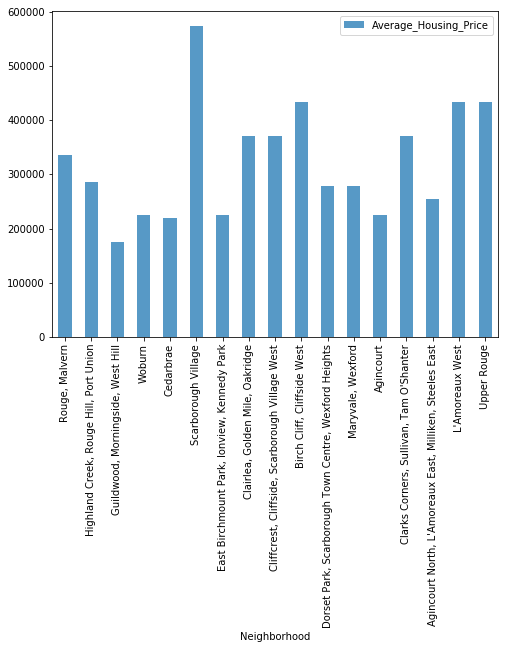

In [41]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(8,6),alpha=0.75)

In [42]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [51]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)

Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,]})

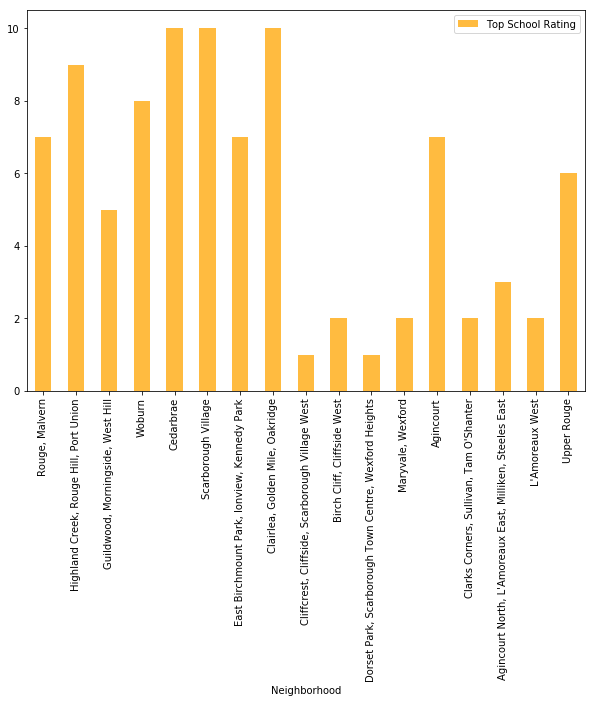

In [52]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

Scarborough_school_ratings.plot(kind='bar',figsize=(10,7),color='orange',alpha=0.75);